In [1]:
"""This notebook generates figrue 5a,b,d,e for the MIST manuscript"""

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sys
sys.path.append("../MIST")
import utils
import neighbors
from sklearn import metrics
import sklearn
sklearn.__version__
from scipy.stats import pearsonr, spearmanr
import numpy as np
import math
from sklearn.preprocessing import RobustScaler,StandardScaler
# from analysis_utils import plot_gene_expr

In [2]:
## READ and normalize raw data
raw,raw_meta = utils.read_ST_data("data/MouseWT/raw.csv")
raw,_ = utils.data_norm(raw, "logCPM")

## READ and normalize imptued data
imp,imp_meta = utils.read_ST_data("../MIST_Imputed/MouseWT_cpm_imputed.csv")
imp = np.log2(imp + 1)

In [3]:
def plot_gene_expr(data, meta, gene, ax, n_outlier=0,c=None):
    """Function to plot non-zero gene expression with outliers"""
    
    meta = meta.loc[data.index,:]
    f = plt.figure(figsize=(3,3))
    
    zero_inds = data.index[data[gene] == 0].to_numpy()
    nonzero_inds = data.index[data[gene] > 0].to_numpy()
    
    # remove outlier
    nonzero_expr = data.loc[nonzero_inds, gene].to_numpy()
    for i in range(n_outlier + 1):
        nonzero_expr = np.delete(nonzero_expr, np.argmin(nonzero_expr))
        nonzero_inds = np.delete(nonzero_inds, np.argmin(nonzero_expr))
    
    nonzero_expr = nonzero_expr.reshape(-1, 1)
    # z-score normalize
    transformer = StandardScaler().fit(nonzero_expr) 
    nonzero_expr = transformer.transform(nonzero_expr)[:,0]
    zero_meta = meta.loc[zero_inds,:]
    nonzero_meta = meta.loc[nonzero_inds,:]
    
    sizes = []
    
    vmin, vmax = np.min(nonzero_expr), np.max(nonzero_expr)
    # normalize size of expression values
    for v in nonzero_expr:
        s = 10 + 35 * (v-vmin)/(vmax-vmin)
        sizes.append(s)
    
    if c == None:
        p = ax.scatter(x=nonzero_meta.coordX.to_numpy(), 
                   y=nonzero_meta.coordY.to_numpy(),
                   c=nonzero_expr,s=sizes,
                   linewidth=0,  cmap='coolwarm')
        cbar = plt.colorbar(p, ax=ax)
    else:
        uniques, cvals = np.unique(meta[c].tolist(), return_inverse=True)
        p = ax.scatter(x=nonzero_meta.coordX.to_numpy(), 
                   y=nonzero_meta.coordY.to_numpy(),
                   c=cvals, s=sizes,
                   linewidth=0,  cmap='coolwarm')
        cbar = f.colorbar(p, cax=ax, boundaries=np.arange(-0.5, len(uniques)+0.5, 1))
        
    ax.scatter(x=zero_meta.coordX.to_numpy(),
               y=zero_meta.coordY.to_numpy(),
               s=5,c='black')
     

    plt.setp(ax, xticks=[], yticks=[])
    ax.invert_yaxis()
    plt.close()
    return f

In [6]:
def gene_pair(gene1, gene2, raw, imputed, meta, n_outlier=0):
    """Method to visualize and quantify the correlation of a pair of gene 
        before and after imputation.
    
    Parameters:
    ----------
    gene1: str, first gene name
    gene2: str, second gene name
    raw: data frame, unimputed data (normalized)
    imptued: data frame, unimputed data (normalzied)
    meta: data frame, coordinates of spots
    n_outlier: number of outliers in the gene expression to be considered
    """
    f, axs = plt.subplots(ncols=3,nrows=2,figsize=(4*3,3.5*2), sharex=False)
    
    # Get Pearson Correlatin Coefficient of gene pair in raw and imputed data
    praw = pearsonr(raw[gene1], raw[gene2])
    pimp = pearsonr(imputed[gene1], imputed[gene2])
    pcc1 = praw[0]
    pcc2 = pimp[0]
    
    # Get Spearman Correlatin Coefficient of gene pair in raw and imputed data
    sraw = spearmanr(raw[gene1], raw[gene2])
    simp = spearmanr(imputed[gene1], imputed[gene2])
    scc1 = sraw[0]
    scc2 = simp[0]

    # Visualize correlation
    axs[0,0].scatter(x=raw[gene1], y=raw[gene2], edgecolors="black", s=40)
    axs[1,0].scatter(x=imputed[gene1], y=imputed[gene2], edgecolors="black", s=40)
    
    axs[0,0].set_ylim(top=raw[gene2].max() + 1.5)
    axs[1,0].set_ylim(top=imputed[gene2].max() + 1.5)
    
    axs[0,0].text(x=raw[gene1].min(),
                  y=raw[gene2].max()+.5, s="r=%.2f" %(scc1),
                  fontsize=14, color="red")
    
    axs[1,0].text(x=imputed[gene1].min(),
                  y=imputed[gene2].max()+.5,
                   s="r=%.2f" %(scc2),
                  fontsize=14, color="red")
    
    axs[0,0].set_xlabel("")
    axs[1,0].set_xlabel("%s (logCPM)" %gene1, fontsize=14)
    axs[0,0].set_ylabel("%s (logCPM)" %gene2, fontsize=14)
    axs[1,0].set_ylabel("%s (logCPM)" %gene2, fontsize=14)
    
    # Plot spatial gene expression patterns of 2 genes in raw and imptued data
    plot_gene_expr(raw, meta, gene1, axs[0,1],n_outlier)
    plot_gene_expr(imputed, meta, gene1, axs[1,1],n_outlier)
    plot_gene_expr(raw, meta, gene2, axs[0,2],n_outlier)
    plot_gene_expr(imputed, meta, gene2, axs[1,2],n_outlier)
    axs[0,1].set_title(gene1, fontsize=14)
    axs[0,2].set_title(gene2, fontsize=14)
    f.subplots_adjust(wspace=0.1, hspace=0.2)
    plt.close()
    return f

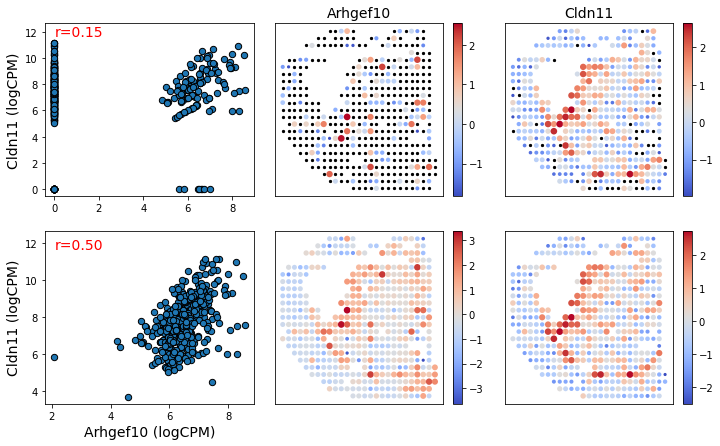

In [7]:
# Figure 5 
gene_pair('Arhgef10', 'Cldn11', raw, imp, raw_meta)

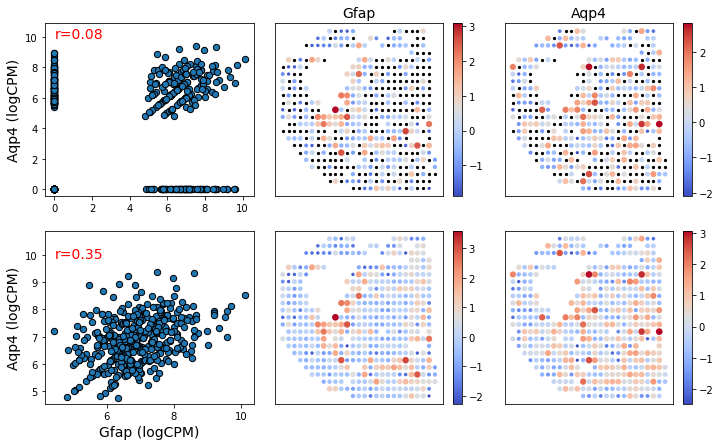

In [8]:
# Figure 5 
gene_pair("Gfap", "Aqp4", raw, imp, raw_meta,0)